# 2 Preprocessing & Training<a id='2_preprocessing_and_training'></a>

## 2.1 Contents<a id='2.1_Contents'></a>
* [2 Data Preprocessing & Training](#2_pre_processing_and_training)
  * [2.1 Contents](#2.1_Contents)
  * [2.2 Introduction](#2.2_Introduction)
  * [2.3 Imports](#2.3_Imports)
  * [2.4 Load The Data](#2.4_Load_The_Data)
  * [2.5 Creating Mel Spectrograms](#2.5_Creating_Mel_Spectrograms)
  * [2.6 Training](#2.6_Training)
  * [2.7 References](#2.7_References)

## 2.2 Introduction<a id='2.2_Introduction'></a>

In the next step we will preprocess the data and train it. The approach we will take in preprocessing the data will be converting the audio files into spectrograms, more specifically, Mel Spectrograms. The reason we make the conversion is because deep learning models do not take raw audio as input. Rather, we turn the audio into a picture that represents the sample and then it becomes similar to an image classification problem. Spectrograms are created using Fourier Transforms, breaking down the audio into all the frequencies it contains and portraying the amplitude of the audio file at specific frequencies with color intensity. That way, three dimensions are used to visualize the sample of audio: time, frequency and amplitude. 

## 2.3 Imports<a id='2.3_Imports'></a>

In [2]:
import os
import pandas as pd
import numpy as np
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim
from torch_lr_finder import LRFinder

import warnings
warnings.filterwarnings("ignore")

/home/notis/.local/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


First we import the appropriate libraries.

## 2.4 Load The Data<a id='2.4_Load_The_Data'></a>

In [3]:
combined_data = pd.read_csv('../data/interim/combined_data.csv',index_col=0)

In [4]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002 entries, 0 to 1001
Columns: 319 entries, Preset to Delta
dtypes: float64(318), object(1)
memory usage: 2.4+ MB


Next, we load the data and quickly inspect it with the .info() method to ensure it remains the same as we had saved it.

## 2.5 Creating Mel Spectrograms<a id='2.5_Creating_Mel_Spectrograms'></a>

This step is the most crucial as it prepares our data for training.

In [5]:
class AudioUtil():
    # ----------------------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    # ----------------------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    
    # ----------------------------
    # Convert the given audio to the desired number of channels
    # ----------------------------
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud
        
        if (sig.shape[0] == new_channel):
            # Nothing to do
            return aud
    
        if (new_channel == 1):
            # Convert from stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            # Convert from mono to stereo by duplicating the first channel
            resig = torch.cat([sig, sig])
        
        return ((resig, sr))
    
    # ----------------------------
    # Since Resample applies to a single channel, we resample one channel at a time
    # ----------------------------
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud
    
        if (sr == newsr):
            # Nothing to do
            return aud
    
        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])
    
            return ((resig, newsr))
            
    # ----------------------------
    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    # ----------------------------
    
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms
        
        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]
        
        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len
            
            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            
            sig = torch.cat((pad_begin, sig, pad_end), 1)
      
        return (sig, sr)
    
    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80
        
        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
        
        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)

First, we create the AudioUtil class which contains several methods to convert the audio into the Mel Spectrogram.

In [6]:
# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
    def __len__(self):
        return len(self.df)    
    
    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        # Absolute file path of the audio file - concatenate the audio directory with
        # the relative path
        audio_file = self.data_path + '/' + self.df.loc[idx, 'Preset']
        # Get the parameters for the audio sample
        parameters = self.df.iloc[idx, 1:].values.astype(np.float32)
        
        aud = AudioUtil.open(audio_file)
        # Some sounds have a higher sample rate, or fewer channels compared to the
        # majority. So make all sounds have the same number of channels and same 
        # sample rate. Unless the sample rate is the same, the pad_trunc will still
        # result in arrays of different lengths, even though the sound duration is
        # the same.
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)
        # shorten = AudioUtil.pad_trunc(rechan, 1000)
        
        sgram = AudioUtil.spectro_gram(rechan, n_mels=64, n_fft=1024, hop_len=None)
        
        return sgram, parameters

Then we create the SoundDS class which defines the desired audio characteristics, fetches the audio files and its respective parameters, then returns the Mel Spectrogram and the parameters.

In [8]:
# Set the audio_path
audio_path = "../data/raw/data_audio"

# Example item check in the dataset
def test_getitem(dataset, index):
    item, targets = dataset[index]
    print(f"Item shape (spectrogram): {item.shape}")
    print(f"First few target values: {targets[:5]}")  # Print first few elements of the targets

# Create an instance of your dataset
dataset = SoundDS(combined_data, audio_path)

# Test __getitem__ on the first item
test_getitem(dataset, 0)

Item shape (spectrogram): torch.Size([2, 64, 431])
First few target values: [0.64 0.75 0.5  0.24 0.5 ]


We test SoundDS to check if it is working as expected and it seems to have loaded the data correctly! Returning the first row in our dataset, it is worth noticing that the column consists of the entire spectrogram object followed by the parameters.

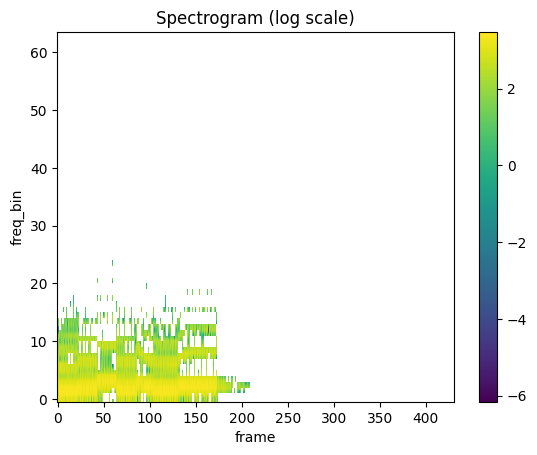

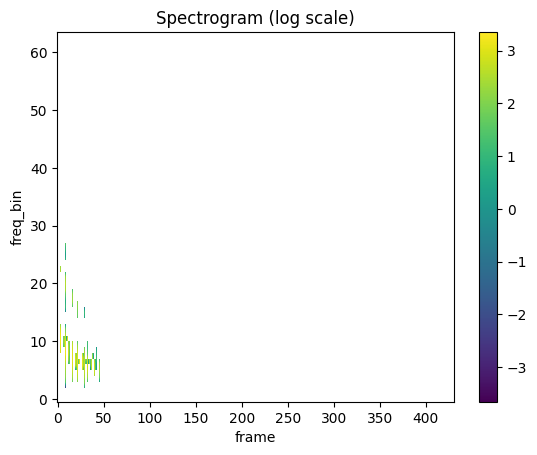

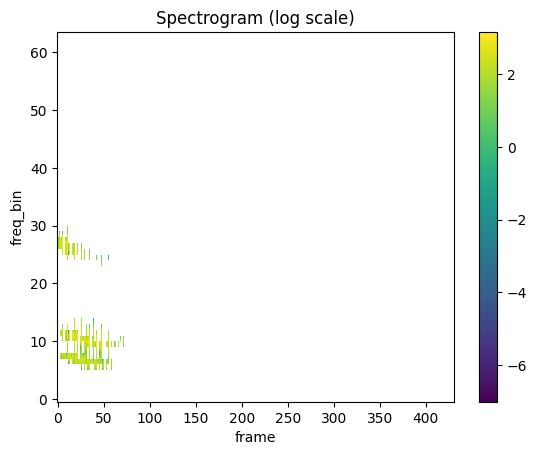

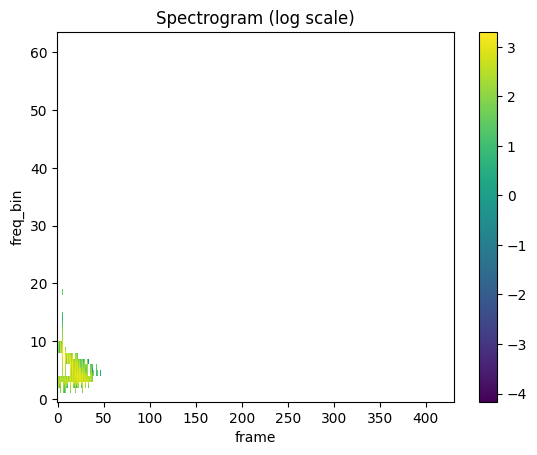

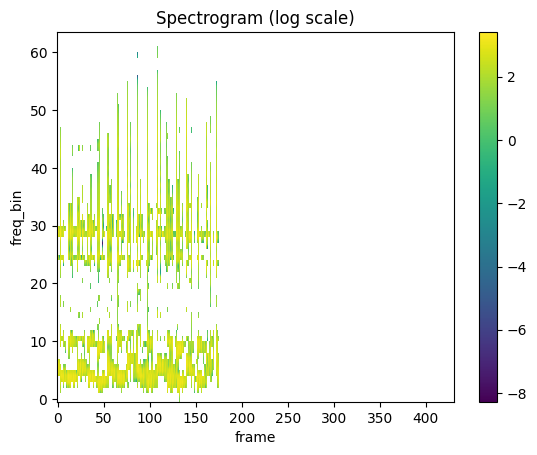

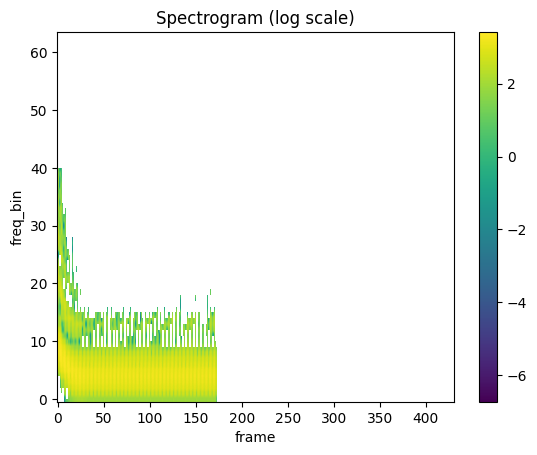

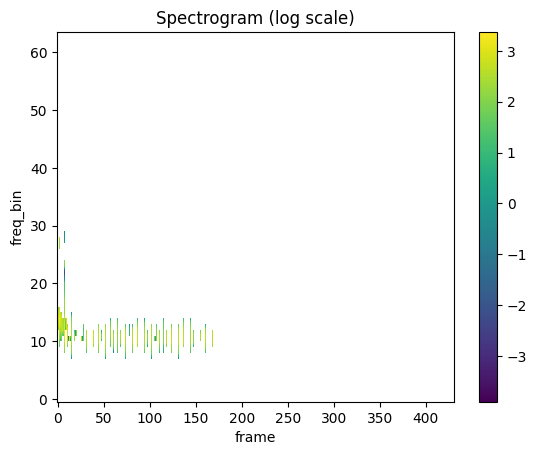

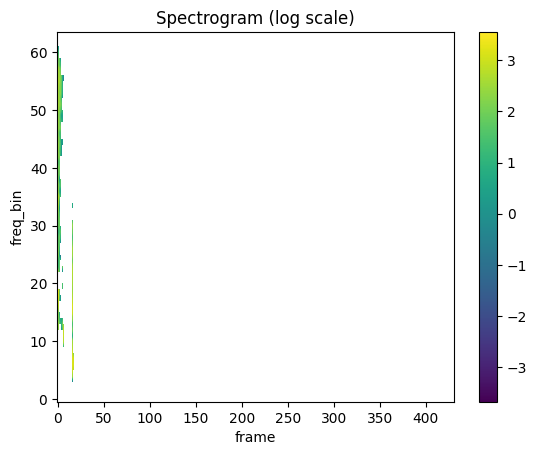

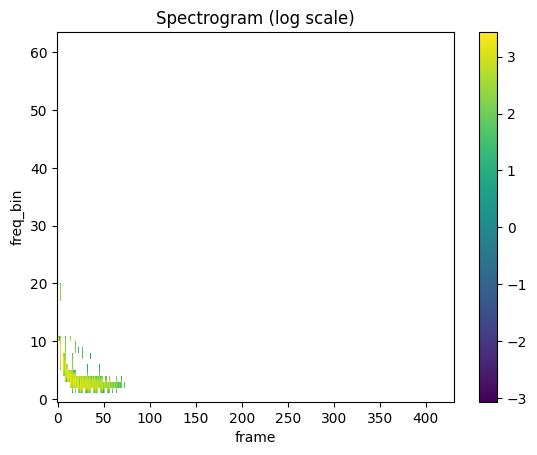

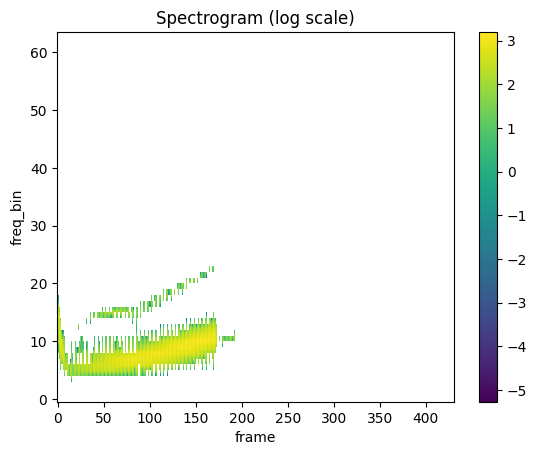

In [9]:
import matplotlib.pyplot as plt

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (log scale)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(torch.log(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
for i in range(10):
    item, targets = dataset[i]
    plot_spectrogram(item[0])  # Plot only the first channel for simplicity

We can even visualize the spectrograms ourselves! Notice how in the first spectrogram outputted, the frequencies are predominantly in the bottom indicating that this sample of audio is bass heavy. The frame displays the length of the audio. Recall that all the samples are two seconds long. Even though the length of the audio is two seconds, the samples may not occupy that entire time because some sounds may be more like a string with sustained note and others like a pluck, such as the second example of the spectrograms which only occupies the frames between 0 and 50.

## 2.6 Training<a id='2.6_Training'></a>

We finally arrive to the training portion.

In [10]:
myds = SoundDS(combined_data, audio_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

First we split the dataset into training and validation sets.

In [12]:
class AudioLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AudioLSTMClassifier, self).__init__()
        
        # Initialize the LSTM layers
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # The regressor to output the desired number of parameters
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.Hardswish(),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Combine batch size and channels, and treat freq_bins as seq_length for the LSTM
        batch_size, channels, freq_bins, time_steps = x.size()
        x = x.view(batch_size, channels * freq_bins, time_steps) 
        x = x.transpose(1, 2)  # LSTM expects [batch_size, seq_length, features]

        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the output of the last time step
        out = out[:, -1, :]
        out = self.regressor(out)
        
        return out

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

    def sanitize_data(inputs, labels):
        # Replace NaNs with a specified value or handle them accordingly
        inputs[torch.isnan(inputs)] = 0
        labels[torch.isnan(labels)] = 0
        return inputs, labels


# Hyperparameters remain the same
input_size = 128
hidden_size = 128
num_layers = 5
num_classes = 318

# Create the model and put it on the GPU if available
myModel = AudioLSTMClassifier(input_size, hidden_size, num_layers, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
myModel.init_weights()
myModel = myModel.to(device)

Next, we define the model we will be training. We chose the Long Short-Term Memory RNN.

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.29E+00


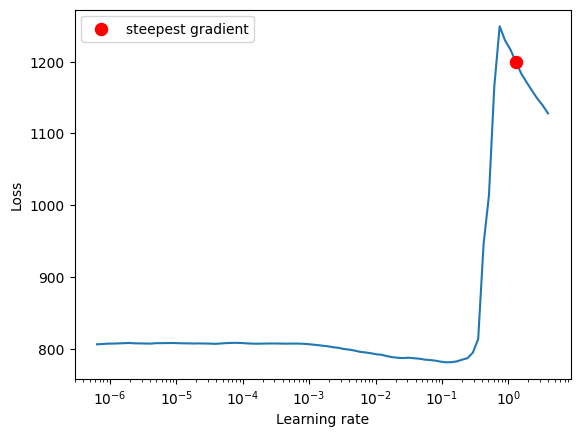

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(myModel.parameters(), lr=1e-7)

# Setup the learning rate finder
lr_finder = LRFinder(myModel, optimizer, criterion, device="cuda" if torch.cuda.is_available() else "cpu")
lr_finder.range_test(train_dl, start_lr=1e-7, end_lr=10, num_iter=100)

# Plotting the results
lr_finder.plot()  # This plots the loss versus learning rate
lr_finder.reset()  # Reset model and optimizer to initial state

Before training the model, we find the optimal learning rate.

In [19]:
# # ----------------------------
# # Training Loop
# # ----------------------------
def training(model, train_dl, num_epochs):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.29)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.29, steps_per_epoch=int(len(train_dl)), epochs=num_epochs, anneal_strategy='linear')

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        processed_batches = 0
        skipped_batches = 0
        for i, data in enumerate(train_dl):
            inputs, labels = data[0].to(device), data[1].to(device)
    
            # Check for NaN or Inf in inputs or labels
            if torch.isnan(inputs).any() or torch.isnan(labels).any() or torch.isinf(inputs).any() or torch.isinf(labels).any():
                print(f"Skipping batch {i} due to NaN or Inf in inputs or labels")
                skipped_batches += 1
                continue
    
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / (inputs_s if inputs_s > 0 else 1.0)
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
    
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Skipping batch {i} due to NaN or Inf in loss")
                skipped_batches += 1
                continue
    
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
    
            if loss.item() > 0:
                running_loss += loss.item()
                processed_batches += 1
            else:
                print(f"Zero loss encountered at batch {i}")
    
        if processed_batches > 0:
            avg_train_loss = running_loss / processed_batches
        else:
            avg_train_loss = 0
        train_losses.append(avg_train_loss)
    
        print(f'Epoch {epoch+1}: Processed {processed_batches}/{len(train_dl)} batches, Skipped {skipped_batches} batches')
        print(f'Train Loss: {avg_train_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in val_dl:
                inputs, labels = data[0].to(device), data[1].to(device)

                # Normalize inputs
                inputs_m, inputs_s = inputs.mean(), inputs.std()
                inputs_s = inputs_s if inputs_s > 0 else 1.0
                inputs = (inputs - inputs_m) / inputs_s

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dl)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.2f}, Val Loss: {avg_val_loss:.2f}')

    print('Finished Training')
    return train_losses, val_losses

  
num_epochs=175   # Uncomment for training loop
# train_losses, val_losses = training(myModel, train_dl, num_epochs)

Skipping batch 46 due to NaN or Inf in inputs or labels
Epoch 1: Processed 50/51 batches, Skipped 1 batches
Train Loss: 0.3257
Epoch 1, Train Loss: 0.33, Val Loss: 0.32
Skipping batch 49 due to NaN or Inf in inputs or labels
Epoch 2: Processed 50/51 batches, Skipped 1 batches
Train Loss: 0.3238
Epoch 2, Train Loss: 0.32, Val Loss: 0.32
Skipping batch 14 due to NaN or Inf in inputs or labels
Epoch 3: Processed 50/51 batches, Skipped 1 batches
Train Loss: 0.3064
Epoch 3, Train Loss: 0.31, Val Loss: 0.26
Skipping batch 27 due to NaN or Inf in inputs or labels
Epoch 4: Processed 50/51 batches, Skipped 1 batches
Train Loss: 0.2027
Epoch 4, Train Loss: 0.20, Val Loss: 0.12
Skipping batch 36 due to NaN or Inf in inputs or labels
Epoch 5: Processed 50/51 batches, Skipped 1 batches
Train Loss: 0.1396
Epoch 5, Train Loss: 0.14, Val Loss: 0.08
Skipping batch 43 due to NaN or Inf in inputs or labels
Epoch 6: Processed 50/51 batches, Skipped 1 batches
Train Loss: 0.1093
Epoch 6, Train Loss: 0.11, V

We then define the training loop of the model. An issue we ran into as we were training the model were missing or infinite values in the inputs to the model. Fortunately, no batches of training data ever contained more than one batch with missing or infinite values; therefore, we skipped the batch and continued with the rest of the batches to train the model.

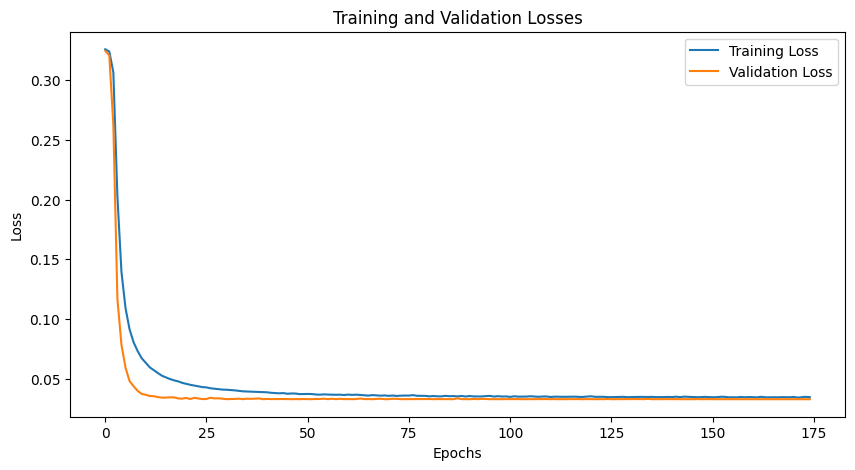

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

To visualize the metric as epochs passed, we graph the training and validation loss. The loss is the MSE. It seems the validation set does not diverge as the training continues. We could certainly reduce the number of epochs trained as the subsequent number of epochs after about 50 do not make a significant difference.

In [19]:
# ----------------------------
# Inference
# ----------------------------
def inference(model, val_dl):
    total_loss = 0.0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for data in val_dl:
            inputs, labels = data[0].to(device), data[1].to(device)

            if torch.isnan(inputs).any() or torch.isnan(labels).any() or torch.isinf(inputs).any() or torch.isinf(labels).any():
                continue  # Skip this batch
            
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_dl)
    print(f'Mean Squared Error on Validation Set: {avg_loss:.2f}')


# Run inference on trained model with the validation set
inference(myModel, val_dl)

Mean Squared Error on Validation Set: 0.03


After the final round of training, the MSE is 0.03 on the validation set, which is a fantastic score!

In [17]:
# Save the model
# torch.save(myModel, 'my_model_2.pth')
# torch.save(myModel.state_dict(), 'model_2_weights.pth')

Finally, lets ensure to save the model and parameters for future modeling.

## 2.7 References<a id='2.7_References'></a>

1. Debnath, S. (2020, December 29). Audio deep learning made simple: Sound classification step-by-step. Towards Data Science. https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5